In [48]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import ta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
import mplfinance as mpf


In [15]:
### DUDAS


# nuestro input es el window size para el LSTM y la cantidad de caracteristicas? diferencia entre las convolusionales 2D?
# si tenemos 2000 datos por feature, cuantas neuronas tenemos de input? 2000? nfeatures segun yo o mas bien, como relaciono el input shape con las neuronas?
# segun yo cada feature representaba una neurona para la capa inicial, o es cada dato, o es independiente?
# lo anterior como sería con convolusionales? los pixeles en convolusionales son features? explicar el por el video que vi
# Para que sirve import tqdm?
# el mismo espacio de tiempo
# mejorar la red neuronal. 
# Usar semillas para el random?


In [91]:
def download_data(ticker: str, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Adj Close']]  
    return data


def preprocess_data(data: pd.DataFrame):
    prices = data
    r = (np.log(prices[['Adj Close']]/prices[['Adj Close']].shift(1))).dropna()
    mean = r.mean()
    std = r.std()
    r_norm = (r - mean)/std 
    
    return prices, r, r_norm, mean, std


def generator(data: pd.DataFrame):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(data.shape[0], 1)))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(LSTM(64))
    model.add(LeakyReLU(negative_slope=0.2) )
    model.add(Dense(252))
    
    return model

def discriminator():
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(252, 1))) ## (252, 1)
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(LSTM(100))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dense(1, activation='sigmoid')) 

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model


@tf.function
def train_step(data, batch_size = 100):
    noise = tf.random.normal([batch_size, len(data), 1])
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = gen_model(noise, training = True)
        
        y_real = disc_model(data, training = True)
        y_fake = disc_model(generated_data, training = True)
        
        gen_loss = -tf.math.reduce_mean(y_fake) # o simplemente -tf.math.reduce_mean(y_fake) y sin las funciones de gen_loss y disc_loss
        disc_loss = tf.reduce_mean(y_fake) - tf.reduce_mean(y_real) #o simplemente tf.reduce_mean(y_fake) - tf.reduce_mean(y_real)
        
        
    gradients_gen = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, disc_model.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, disc_model.trainable_variables))
    
    
    return gen_loss, disc_loss



class Position:
    def __init__(self, ticker: str, price: float, n_shares: int):
        self.ticker = ticker
        self.price = price
        self.n_shares = n_shares
        
        
def backtest(data: pd.DataFrame, sl: float, tp: float,
             n_shares: int, rf = 0):
    
    
    data = data.copy()

    data.columns.values[0] = "Close"
    
    bollinger = ta.volatility.BollingerBands(data.Close, window=20)
    data['BB_Buy'] = bollinger.bollinger_lband_indicator()

    

    capital = 1_000_000
    COM = 0.125 / 100  # Commission percentage
    active_long_positions = []
    portfolio_value = [capital]
     
    
    wins = 0
    losses = 0

    # Iterar sobre los datos del mercado
    for i, row in data.iterrows():
        long_signal = row.BB_Buy  # Señal de compra

        # Entrada de posición larga
        if long_signal == True:
            cost = row.Close * n_shares * (1 + COM)
            if capital > cost and len(active_long_positions) < 100:
                capital -= row.Close * n_shares * (1 + COM)
                active_long_positions.append(
                    Position(ticker="MANU", price=row.Close, n_shares=n_shares))

      

        # Cierre de posiciones largas
        for position in active_long_positions.copy():
            if row.Close > position.price * (1 + tp):
                capital += row.Close * position.n_shares * (1 - COM)
                wins += 1  # Operación ganadora
                active_long_positions.remove(position)
            elif row.Close < position.price * (1 - sl):
                capital += row.Close * position.n_shares * (1 - COM)
                losses += 1  # Operación perdedora
                active_long_positions.remove(position)
        
        value = capital + len(active_long_positions) * n_shares * row.Close       
        portfolio_value.append(value)


    # Convertir portfolio_value a una Serie de pandas
    portfolio_series = pd.Series(portfolio_value)

    # Calcular el rendimiento logarítmico
    portafolio_value_rends = np.log(portfolio_series / portfolio_series.shift(1))
    
        # Calcular el Sharpe Ratio
    mean_portfolio_return = portafolio_value_rends.mean()  # Rendimiento promedio del portafolio
    portfolio_volatility = portafolio_value_rends.std()  # Volatilidad del portafolio
    sharpe_ratio = (mean_portfolio_return - rf) / portfolio_volatility  # Sharpe Ratio

    #print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    # Calcular el valor máximo acumulado en cada momento
    running_max = portfolio_series.cummax()

    # Calcular el Drawdown
    drawdown = (portfolio_series - running_max) / running_max

    # Max Drawdown
    max_drawdown = drawdown.min()

    #print(f"Max Drawdown: {max_drawdown:.4f}")

    # Calcular el Win-Loss Ratio
    if losses > 0:
        win_loss_ratio = wins / losses
    else:
        win_loss_ratio = np.inf  # Si no hay pérdidas, el Win-Loss ratio es infinito

    passive = list(data.Close)

    #print(f"Win-Loss Ratio: {win_loss_ratio:.2f}")


    calmar_value = calmar_ratio(portafolio_value_rends)
    

    return calmar_value, portfolio_series


def backtest2(data: pd.DataFrame, sl: float, tp: float, n_shares: int, rf=0):
    data = data.copy()
    
    # Asegurar que las columnas OHLC existen
    if 'Open' not in data.columns:
        data['Open'] = data['Close']
    if 'High' not in data.columns:
        data['High'] = data['Close']
    if 'Low' not in data.columns:
        data['Low'] = data['Close']
    
    # Calcular las Bandas de Bollinger y señales de compra
    bollinger = ta.volatility.BollingerBands(data['Close'], window=20)
    data['BB_Low'] = bollinger.bollinger_lband()
    data['BB_Buy'] = bollinger.bollinger_lband_indicator()

    capital = 1_000_000
    COM = 0.125 / 100  # Comisión en porcentaje
    active_long_positions = []
    portfolio_value = [capital]
    cash_through_time = [capital]
    operations = []  # Lista para almacenar cada operación
    buy_signals = pd.Series(np.nan, index=data.index)  # Para almacenar precios de compra con NaN por defecto
    
    wins = 0
    losses = 0

    # Iterar sobre los datos del mercado
    for i, row in data.iterrows():
        long_signal = row['BB_Buy']  # Señal de compra

        # Entrada de posición larga
        if long_signal == True:
            cost = row['Close'] * n_shares * (1 + COM)
            if capital > cost and len(active_long_positions) < 100:
                capital -= cost
                position = Position(ticker="MANU", price=row['Close'], n_shares=n_shares)
                active_long_positions.append(position)
                operations.append({
                    'Type': 'Buy',
                    'Price': row['Close'],
                    'Shares': n_shares,
                    'Total Cost': cost,
                    'Date': row.name
                })
                buy_signals[row.name] = row['Close']  # Almacenar el precio de compra en la fecha correspondiente

        # Cierre de posiciones largas
        for position in active_long_positions.copy():
            if row['Close'] > position.price * (1 + tp):
                revenue = row['Close'] * position.n_shares * (1 - COM)
                capital += revenue
                wins += 1
                active_long_positions.remove(position)
                operations.append({
                    'Type': 'Sell (Take Profit)',
                    'Price': row['Close'],
                    'Shares': position.n_shares,
                    'Total Revenue': revenue,
                    'Date': row.name
                })
            elif row['Close'] < position.price * (1 - sl):
                revenue = row['Close'] * position.n_shares * (1 - COM)
                capital += revenue
                losses += 1
                active_long_positions.remove(position)
                operations.append({
                    'Type': 'Sell (Stop Loss)',
                    'Price': row['Close'],
                    'Shares': position.n_shares,
                    'Total Revenue': revenue,
                    'Date': row.name
                })

        # Valor del portafolio y efectivo en el tiempo
        value = capital + sum(p.n_shares * row['Close'] for p in active_long_positions)
        portfolio_value.append(value)
        cash_through_time.append(capital)

    # Convertir `portfolio_value` y `cash_through_time` a Series de pandas
    portfolio_series = pd.Series(portfolio_value)
    cash_series = pd.Series(cash_through_time)

    # Calcular el rendimiento logarítmico
    portafolio_value_rends = np.log(portfolio_series / portfolio_series.shift(1))

    # Calcular el Sharpe Ratio
    mean_portfolio_return = portafolio_value_rends.mean()
    portfolio_volatility = portafolio_value_rends.std()
    sharpe_ratio = (mean_portfolio_return - rf) / portfolio_volatility
    
    # Calcular el rendimiento del portafolio a lo largo del periodo
    initial_value = portfolio_series.iloc[0]
    final_value = portfolio_series.iloc[-1]
    portfolio_return = ((final_value - initial_value) / initial_value) * 100  # Porcentaje


    # Calmar Ratio
    calmar_value = calmar_ratio(portafolio_value_rends)

    # Gráfico de Velas con Banda Baja de Bollinger y Señales de Compra
    add_plot = [
        mpf.make_addplot(data['BB_Low'], color='green', label='Banda Baja de Bollinger'),  # Solo muestra la banda baja
        mpf.make_addplot(buy_signals, scatter=True, markersize=50, marker='o', color='purple', label='Señal de Compra')  # Señales de compra
    ]

    # Crear un gráfico de línea
    fig, axlist = mpf.plot(data, type='line', style='charles', addplot=add_plot, title="Bandas de Bollinger y Señales de Compra", returnfig=True)
    
    # Añadir una leyenda manualmente
    axlist[0].legend(['Precio de Cierre', 'Banda Baja de Bollinger', 'Señal de Compra'], loc='upper left')
    
    # Mostrar el gráfico del valor del portafolio y efectivo en el tiempo
    plt.figure(figsize=(14, 7))
    plt.plot(cash_series, label='Efectivo en el Tiempo', color='orange')
    plt.title("Efectivo en el Tiempo")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    
 # Gráfico del valor del portafolio y el precio a lo largo del tiempo (usando dos ejes)
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Gráfico del precio en el eje primario (eje izquierdo)
    ax1.plot(data['Close'].values, label='Precio de Cierre', color='blue')
    ax1.set_xlabel("Índice")
    ax1.set_ylabel("Precio", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Gráfico del valor del portafolio en el eje secundario (eje derecho)
    ax2 = ax1.twinx()
    ax2.plot(portfolio_series.values, label='Valor del Portafolio', color='green')
    ax2.set_ylabel("Valor del Portafolio", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Título y leyenda
    plt.title("Precio de Cierre y Valor del Portafolio a través del Tiempo")
    fig.tight_layout()  # Ajusta el diseño para evitar solapamiento
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

    # Retornar resultados y métricas
    return {
        'Calmar Ratio': calmar_value,
        'Sharpe Ratio': sharpe_ratio,
        'Win-Loss Ratio': wins / losses if losses > 0 else np.inf,
        'Portfolio Return (%)': portfolio_return
    }
    


def calmar_ratio(returns):
    max_drawdown = (returns.cummax() - returns).max()
    annual_return = returns.mean() * 252  # Asumiendo 252 días de trading en un año
    return annual_return / abs(max_drawdown)

In [40]:
ticker = "MANU"  
start_date = '2014-10-29'
end_date = '2024-10-30'
data = download_data(ticker, start_date, end_date)
precios, data, data_norm, mean, std = preprocess_data(data)
gen_model = generator(data_norm)
disc_model = discriminator()

precios = precios.rename(columns={'Adj Close': 'Close'})

[*********************100%%**********************]  1 of 1 completed
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

gen_loss_history = []
disc_loss_history = []

num_batches = data_norm.shape[0] // 200
for epoch in range(100):
    for i in tqdm.tqdm(range(num_batches)):
        batch = data_norm[i*200:(1+i)*200]
        gen_loss, disc_loss = train_step(batch)

        gen_loss_history.append(gen_loss.numpy())
        disc_loss_history.append(disc_loss.numpy())

100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


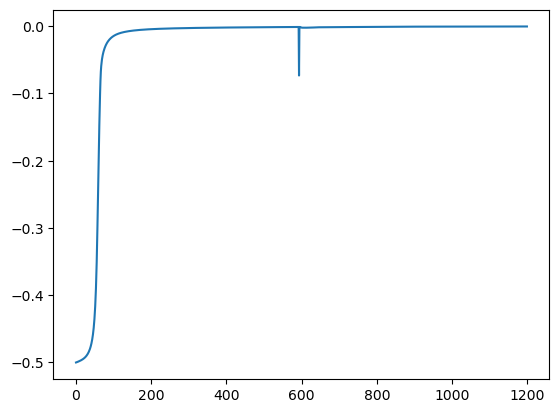

In [19]:
plt.plot(gen_loss_history) # se tiene que acercar a cero. por que?

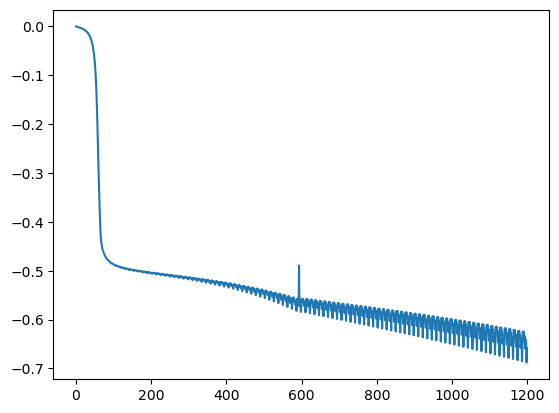

In [20]:
plt.plot(disc_loss_history) # se tiene que alejar mas. por que?

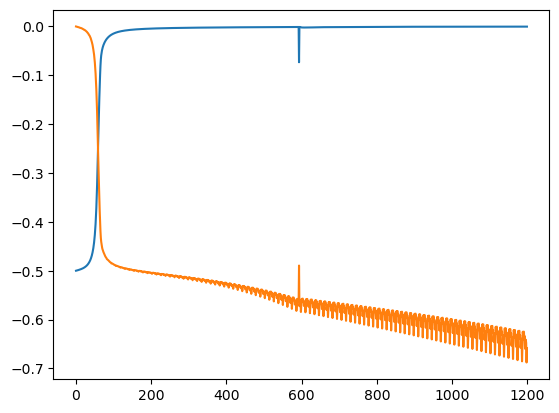

In [21]:
plt.plot(gen_loss_history)
plt.plot(disc_loss_history)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


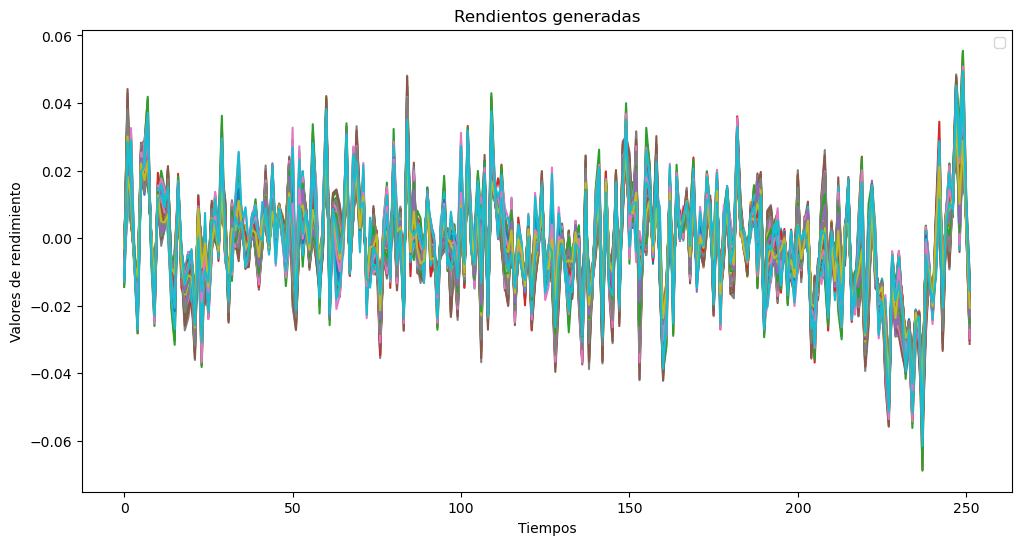

In [27]:
gen2 = tf.keras.models.load_model("./generador.keras")
noise = tf.random.normal([100, 2000, 1])  

generated_series = gen2(noise, training=False)  

plt.figure(figsize=(12, 6))
for j in range(100):  
    plt.plot(generated_series[j, :])

plt.title("Rendientos generadas")
plt.xlabel("Tiempos")
plt.ylabel("Valores de rendimiento")
plt.legend()
plt.show()

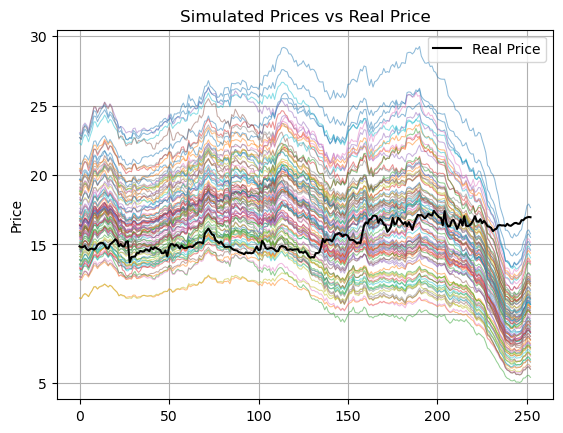

In [35]:
scenarios = generated_series.numpy().tolist()

data_n = []

for scenario in scenarios:
    S0 = precios['Adj Close'].sample(n=1).iloc[0]
    prices = [S0]
    for log_return in scenario:
        next_price = prices[-1] * np.exp(log_return)
        prices.append(next_price)
    data_n.append(prices)

for prices in data_n:
    plt.plot(prices, alpha=0.5, linewidth=0.75)

plt.plot((precios.iloc[:253]).values, label='Real Price', color='black', linewidth=1.5)
plt.title('Simulated Prices vs Real Price')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


In [30]:
scenarios_df = pd.DataFrame()
for i in range(len(data_n)):
    scenarios_df[f'Simulación {i+1}'] = data_n[i]
    
scenarios_df['Close'] = precios['Adj Close'].iloc[:253].values  # agregar precio original
scenarios_df

C:\Users\HP\AppData\Local\Temp\ipykernel_28244\2788055232.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scenarios_df['Close'] = precios['Adj Close'].iloc[:253].values  # agregar precio original


,Simulación 1,Simulación 2,Simulación 3,Simulación 4,Simulación 5,Simulación 6,Simulación 7,Simulación 8,Simulación 9,Simulación 10,...,Simulación 92,Simulación 93,Simulación 94,Simulación 95,Simulación 96,Simulación 97,Simulación 98,Simulación 99,Simulación 100,Close
0,16.228800,16.078594,15.685647,18.719999,19.070673,12.610000,14.888473,23.180000,18.430000,16.315762,...,14.702550,23.559999,18.749992,15.921312,18.734411,19.430000,16.349091,15.685647,23.090000,14.860147
1,16.180849,15.957504,15.638115,18.463754,19.001251,12.534910,14.755026,23.129658,18.352612,16.198483,...,14.629322,23.454444,18.631592,15.872428,18.622336,19.262106,16.286991,15.639344,22.794310,14.795254
2,16.406177,16.417760,15.985148,18.781967,19.496489,13.057725,15.075008,23.404153,18.695319,16.618509,...,14.884311,24.122266,19.106334,16.245616,18.973684,19.634103,16.668620,15.926782,23.453772,14.813793
3,16.689102,16.584436,16.109693,19.398343,19.642965,13.125093,15.313539,23.846352,18.915269,16.819881,...,15.073950,24.303750,19.325713,16.376528,19.230957,19.992208,16.812562,16.121216,23.842959,14.897224
4,16.591366,16.514112,16.004428,19.252572,19.509038,13.074905,15.213651,23.724661,18.789721,16.720585,...,14.968473,24.163934,19.224332,16.256523,19.099845,19.844275,16.715763,15.994921,23.711250,14.656200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,11.221237,9.365921,9.251206,14.299666,10.318306,5.287100,9.950056,16.528538,11.989752,9.757887,...,9.992831,12.378002,11.071448,8.876654,12.743088,13.297982,10.054659,9.742982,13.810090,16.747759
249,11.390043,9.531500,9.312501,14.746887,10.362567,5.310314,10.129804,16.755628,12.155041,9.912721,...,10.154333,12.399077,11.283874,8.913452,12.947538,13.595922,10.159204,9.841966,14.147812,16.887169
250,11.795072,9.850016,9.535712,15.581299,10.621387,5.457715,10.505601,17.350278,12.515777,10.253262,...,10.458322,12.741446,11.656147,9.137124,13.362627,14.128149,10.417913,10.130001,14.739221,16.942934
251,11.839731,9.916003,9.583171,15.756737,10.681241,5.500147,10.586855,17.415256,12.577942,10.318348,...,10.514989,12.795467,11.731313,9.185900,13.444900,14.231484,10.479264,10.167858,14.881429,16.980112


In [31]:
# Solo 10 combinaciones de sl y tp
combinations = [
    (0.01, 0.02),
    (0.01, 0.05),
    (0.01, 0.08),
    (0.02, 0.02),
    (0.02, 0.05),
    (0.02, 0.08),
    (0.03, 0.02),
    (0.03, 0.05),
    (0.03, 0.08),
    (0.025, 0.025)  # Agrega cualquier combinación adicional específica
]

results = []

# Loop para cada combinación en la lista predefinida
for sl, tp in combinations:
    calmar_ratios = []

    # Ejecuta 10 simulaciones por combinación
    num_simulations = len(scenarios)
    for i in range(num_simulations):
        # Ejecuta el backtest con la combinación actual
        calmar, _ = backtest(scenarios_df.iloc[:, [i]], sl=sl, tp=tp, n_shares=20)
        calmar_ratios.append(calmar)

    # Calcula la media del Calmar Ratio para esta combinación
    mean_calmar_ratio = np.mean(calmar_ratios)

    # Guarda los resultados
    results.append({
        "sl": sl,
        "tp": tp,
        "mean_calmar_ratio": mean_calmar_ratio
    })

# Imprimir los resultados
for result in results:
    print(f"SL: {result['sl']}, TP: {result['tp']}, Media del Calmar Ratio: {result['mean_calmar_ratio']:.4f}")


SL: 0.01, TP: 0.02, Media del Calmar Ratio: -0.8474
SL: 0.01, TP: 0.05, Media del Calmar Ratio: -0.7257
SL: 0.01, TP: 0.08, Media del Calmar Ratio: -0.5986
SL: 0.02, TP: 0.02, Media del Calmar Ratio: -0.8685
SL: 0.02, TP: 0.05, Media del Calmar Ratio: -0.7277
SL: 0.02, TP: 0.08, Media del Calmar Ratio: -0.5735
SL: 0.03, TP: 0.02, Media del Calmar Ratio: -0.8425
SL: 0.03, TP: 0.05, Media del Calmar Ratio: -0.6781
SL: 0.03, TP: 0.08, Media del Calmar Ratio: -0.5233
SL: 0.025, TP: 0.025, Media del Calmar Ratio: -0.8180


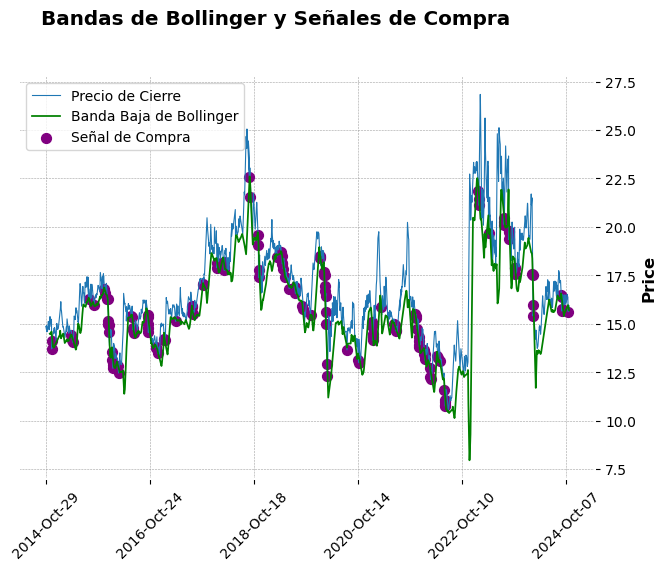

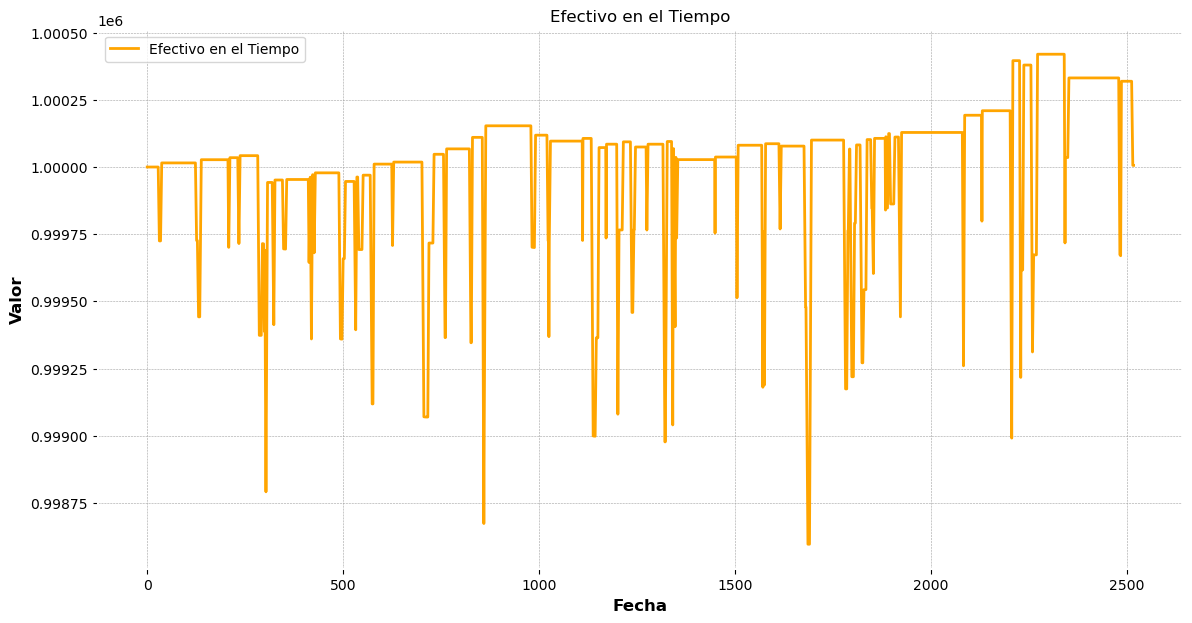

<Figure size 1400x700 with 0 Axes>

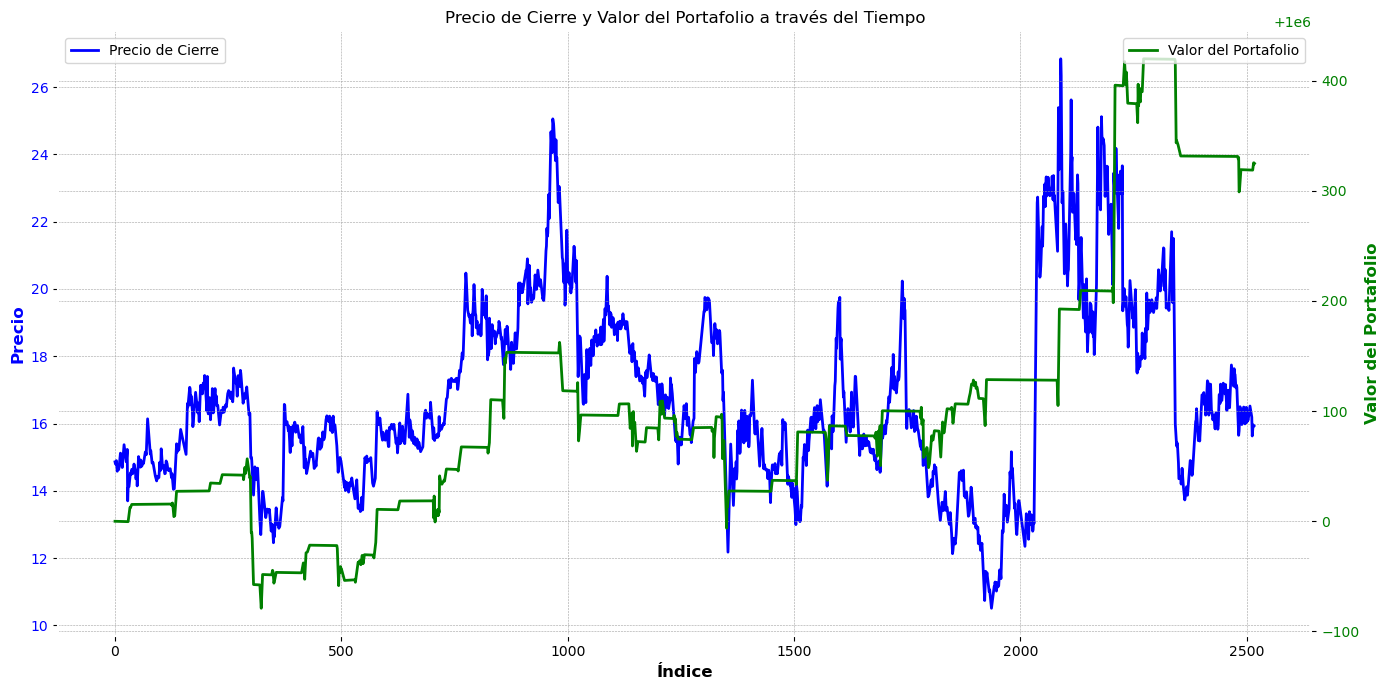

{'Calmar Ratio': 0.13695112201078238,
 'Sharpe Ratio': 0.02132973641335369,
 'Win-Loss Ratio': 1.3833333333333333,
 'Portfolio Return (%)': 0.03247375506878598}

In [92]:
trading = backtest2(precios, sl=sl, tp=tp, n_shares=20)
trading